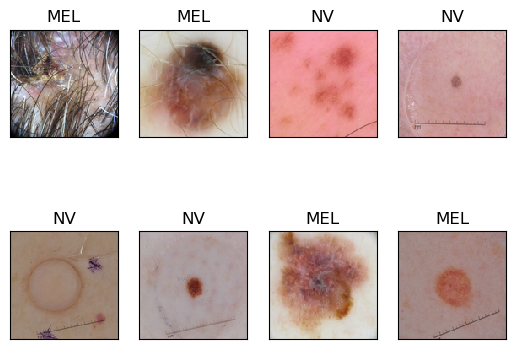

In [3]:
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

folder = ImageFolder('a5_data/train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

In [4]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load training and validation datasets
train_dataset = datasets.ImageFolder(root='a5_data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)

# Function to plot training and validation accuracy
def plot_accuracies(training_accuracies, validation_accuracies):
    epochs = list(range(1, len(training_accuracies) + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_accuracies, label='Training Accuracy')
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()


# Evaluate the model
def evaluate_model(model, test_loader, device, verbose=True):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():  # No gradient tracking needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if verbose:
        print(f'Accuracy of the model on the test images: {accuracy} %')
    return accuracy


# Train the model
def train_model(model,model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    training_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_accuracy = 100 * correct / total
        training_accuracies.append(training_accuracy)

        # Evaluate after every epoch
        val_accuracy = evaluate_model(model, val_loader, device, verbose=False)
        validation_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Training Accuracy: {training_accuracy:.2f} %, '
              f'Validation Accuracy: {val_accuracy:.2f} %')
    
        # Save the model checkpoint
        torch.save(model.state_dict(), f'model/{model_name}_{epoch}_{val_accuracy:.2f}.pth')
    return training_accuracies, validation_accuracies  

Epoch [1/10], Loss: 0.3915, Training Accuracy: 82.79 %, Validation Accuracy: 86.02 %
Epoch [2/10], Loss: 0.3315, Training Accuracy: 84.64 %, Validation Accuracy: 84.03 %
Epoch [3/10], Loss: 0.2922, Training Accuracy: 86.82 %, Validation Accuracy: 86.02 %
Epoch [4/10], Loss: 0.2723, Training Accuracy: 88.13 %, Validation Accuracy: 86.66 %
Epoch [5/10], Loss: 0.2657, Training Accuracy: 87.85 %, Validation Accuracy: 84.19 %
Epoch [6/10], Loss: 0.2282, Training Accuracy: 90.23 %, Validation Accuracy: 84.50 %
Epoch [7/10], Loss: 0.2080, Training Accuracy: 91.67 %, Validation Accuracy: 85.62 %
Epoch [8/10], Loss: 0.1800, Training Accuracy: 92.92 %, Validation Accuracy: 80.99 %
Epoch [9/10], Loss: 0.1384, Training Accuracy: 94.65 %, Validation Accuracy: 85.14 %
Epoch [10/10], Loss: 0.1133, Training Accuracy: 95.70 %, Validation Accuracy: 86.74 %


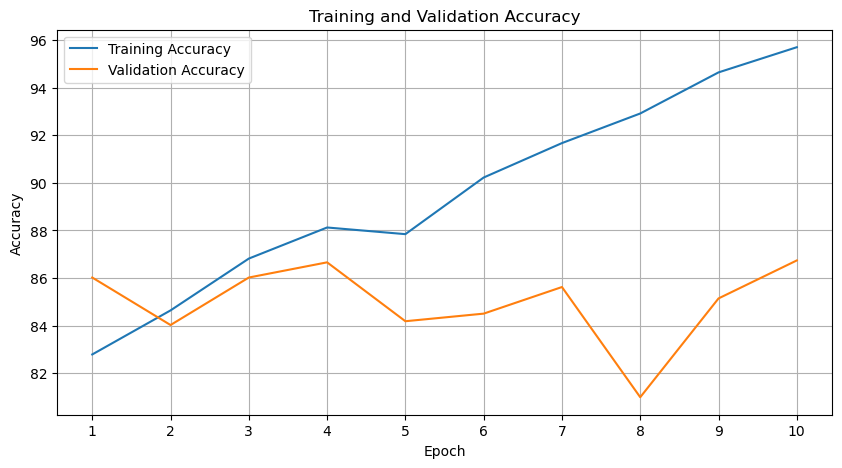

Accuracy of the model on the test images: 86.74121405750799 %


In [8]:
# Load a pretrained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resnet_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(resnet_model, 'resnet_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(resnet_model, val_loader, device=device)

/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/wilsonlee/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:09<00:00, 11.3MB/s]


Epoch [1/10], Loss: 0.4055, Training Accuracy: 81.57 %, Validation Accuracy: 81.55 %
Epoch [2/10], Loss: 0.3406, Training Accuracy: 84.50 %, Validation Accuracy: 81.79 %
Epoch [3/10], Loss: 0.3304, Training Accuracy: 84.98 %, Validation Accuracy: 81.87 %
Epoch [4/10], Loss: 0.3180, Training Accuracy: 86.12 %, Validation Accuracy: 82.83 %
Epoch [5/10], Loss: 0.3063, Training Accuracy: 85.95 %, Validation Accuracy: 82.99 %
Epoch [6/10], Loss: 0.2899, Training Accuracy: 87.02 %, Validation Accuracy: 85.38 %
Epoch [7/10], Loss: 0.2815, Training Accuracy: 87.43 %, Validation Accuracy: 84.90 %
Epoch [8/10], Loss: 0.2751, Training Accuracy: 88.14 %, Validation Accuracy: 85.78 %
Epoch [9/10], Loss: 0.2637, Training Accuracy: 88.39 %, Validation Accuracy: 86.02 %
Epoch [10/10], Loss: 0.2363, Training Accuracy: 89.92 %, Validation Accuracy: 84.50 %


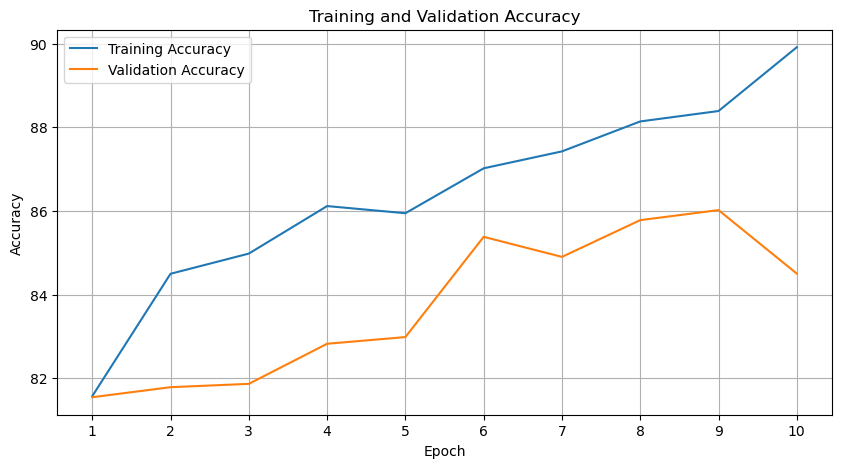

Accuracy of the model on the test images: 84.50479233226837 %


In [9]:
# Load a pretrained ResNet model
resnet50_model = models.resnet50(pretrained=True)

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resnet50_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(resnet50_model, 'resnet50_model', train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(resnet50_model, val_loader, device=device)


# Data Augmentation

/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.5020, Training Accuracy: 75.49 %, Validation Accuracy: 83.63 %
Epoch [2/20], Loss: 0.4202, Training Accuracy: 80.80 %, Validation Accuracy: 86.02 %
Epoch [3/20], Loss: 0.4031, Training Accuracy: 80.84 %, Validation Accuracy: 86.02 %
Epoch [4/20], Loss: 0.4028, Training Accuracy: 81.05 %, Validation Accuracy: 83.55 %
Epoch [5/20], Loss: 0.4406, Training Accuracy: 80.08 %, Validation Accuracy: 84.50 %
Epoch [6/20], Loss: 0.3872, Training Accuracy: 81.92 %, Validation Accuracy: 83.47 %
Epoch [7/20], Loss: 0.3803, Training Accuracy: 82.59 %, Validation Accuracy: 83.23 %
Epoch [8/20], Loss: 0.3726, Training Accuracy: 83.15 %, Validation Accuracy: 83.87 %
Epoch [9/20], Loss: 0.3655, Training Accuracy: 82.70 %, Validation Accuracy: 80.59 %
Epoch [10/20], Loss: 0.3584, Training Accuracy: 83.02 %, Validation Accuracy: 86.66 %
Epoch [11/20], Loss: 0.3635, Training Accuracy: 83.47 %, Validation Accuracy: 85.14 %
Epoch [12/20], Loss: 0.3717, Training Accuracy: 83.38 %, Valida

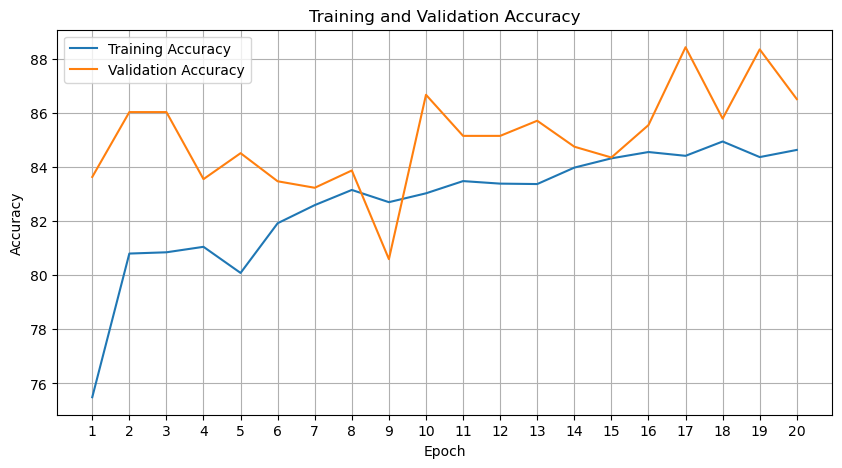

Accuracy of the model on the test images: 86.50159744408946 %


In [11]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a pretrained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resnet_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(resnet_model, 'resnet18_da_model', train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(resnet_model, val_loader, device=device)


/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.4761, Training Accuracy: 76.41 %, Validation Accuracy: 84.19 %
Epoch [2/20], Loss: 0.4259, Training Accuracy: 79.77 %, Validation Accuracy: 82.99 %
Epoch [3/20], Loss: 0.4158, Training Accuracy: 79.82 %, Validation Accuracy: 84.50 %
Epoch [4/20], Loss: 0.3825, Training Accuracy: 82.32 %, Validation Accuracy: 84.19 %
Epoch [5/20], Loss: 0.3916, Training Accuracy: 81.25 %, Validation Accuracy: 83.71 %
Epoch [6/20], Loss: 0.3708, Training Accuracy: 82.82 %, Validation Accuracy: 83.71 %
Epoch [7/20], Loss: 0.3736, Training Accuracy: 82.52 %, Validation Accuracy: 85.70 %
Epoch [8/20], Loss: 0.3796, Training Accuracy: 82.70 %, Validation Accuracy: 85.86 %
Epoch [9/20], Loss: 0.3786, Training Accuracy: 82.34 %, Validation Accuracy: 86.18 %
Epoch [10/20], Loss: 0.3601, Training Accuracy: 83.44 %, Validation Accuracy: 85.46 %
Epoch [11/20], Loss: 0.3518, Training Accuracy: 84.08 %, Validation Accuracy: 86.02 %
Epoch [12/20], Loss: 0.3598, Training Accuracy: 83.19 %, Valida

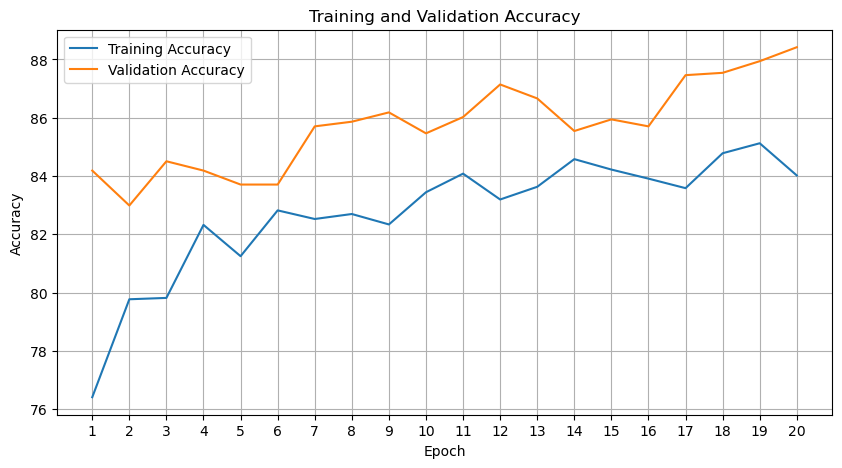

Accuracy of the model on the test images: 88.4185303514377 %


In [12]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a pretrained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resnet_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(resnet_model, 'resnet18_da_1_model', train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(resnet_model, val_loader, device=device)


Epoch [1/25], Loss: 0.4854, Training Accuracy: 76.38 %, Validation Accuracy: 81.15 %
Epoch [2/25], Loss: 0.4376, Training Accuracy: 78.96 %, Validation Accuracy: 83.87 %
Epoch [3/25], Loss: 0.4090, Training Accuracy: 79.66 %, Validation Accuracy: 82.35 %
Epoch [4/25], Loss: 0.3947, Training Accuracy: 80.91 %, Validation Accuracy: 82.43 %
Epoch [5/25], Loss: 0.3893, Training Accuracy: 81.33 %, Validation Accuracy: 84.90 %
Epoch [6/25], Loss: 0.3842, Training Accuracy: 82.15 %, Validation Accuracy: 85.54 %
Epoch [7/25], Loss: 0.3801, Training Accuracy: 81.98 %, Validation Accuracy: 86.10 %
Epoch [8/25], Loss: 0.4175, Training Accuracy: 80.27 %, Validation Accuracy: 85.70 %
Epoch [9/25], Loss: 0.3727, Training Accuracy: 82.26 %, Validation Accuracy: 84.03 %
Epoch [10/25], Loss: 0.3721, Training Accuracy: 82.48 %, Validation Accuracy: 83.31 %
Epoch [11/25], Loss: 0.3707, Training Accuracy: 82.71 %, Validation Accuracy: 82.03 %
Epoch [12/25], Loss: 0.3721, Training Accuracy: 82.74 %, Valida

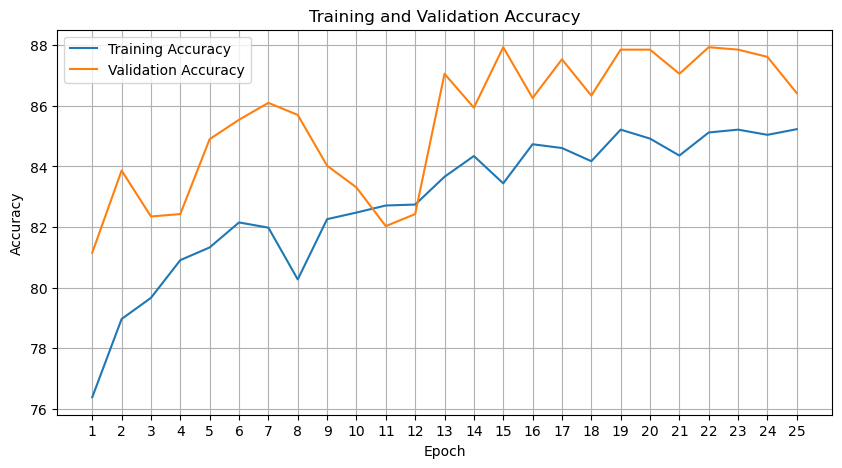

Accuracy of the model on the test images: 86.42172523961662 %


In [14]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a pretrained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resnet_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(resnet_model, 'resnet18_da_2_model', train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(resnet_model, val_loader, device=device)



/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.4909, Training Accuracy: 75.09 %, Validation Accuracy: 77.48 %
Epoch [2/20], Loss: 0.4193, Training Accuracy: 78.68 %, Validation Accuracy: 80.51 %
Epoch [3/20], Loss: 0.4147, Training Accuracy: 79.58 %, Validation Accuracy: 83.07 %
Epoch [4/20], Loss: 0.3971, Training Accuracy: 81.34 %, Validation Accuracy: 83.15 %
Epoch [5/20], Loss: 0.3851, Training Accuracy: 81.50 %, Validation Accuracy: 83.47 %
Epoch [6/20], Loss: 0.4172, Training Accuracy: 80.11 %, Validation Accuracy: 83.87 %
Epoch [7/20], Loss: 0.4089, Training Accuracy: 80.64 %, Validation Accuracy: 85.14 %
Epoch [8/20], Loss: 0.3907, Training Accuracy: 81.33 %, Validation Accuracy: 84.66 %
Epoch [9/20], Loss: 0.3742, Training Accuracy: 81.84 %, Validation Accuracy: 85.22 %
Epoch [10/20], Loss: 0.3780, Training Accuracy: 82.26 %, Validation Accuracy: 83.71 %
Epoch [11/20], Loss: 0.3730, Training Accuracy: 83.05 %, Validation Accuracy: 85.46 %
Epoch [12/20], Loss: 0.3752, Training Accuracy: 82.09 %, Valida

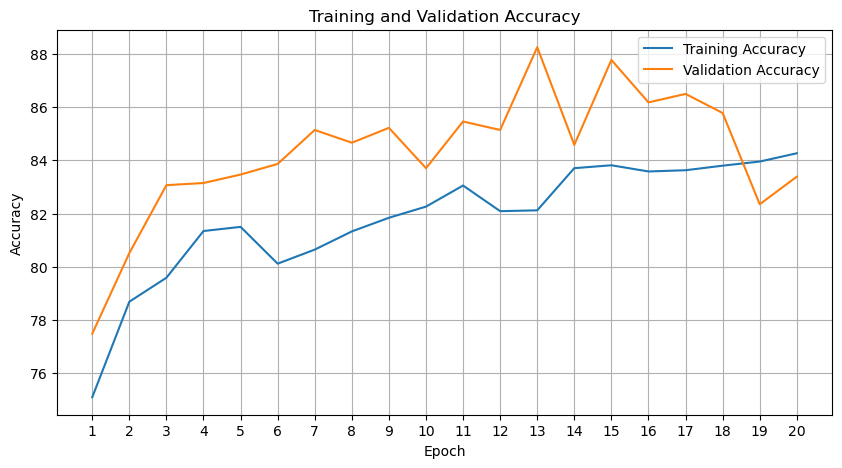

Accuracy of the model on the test images: 83.38658146964856 %


In [5]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a pretrained ResNet model
resnet50_model = models.resnet50(pretrained=True)

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resnet50_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(resnet50_model, 'resnet50_model', train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(resnet50_model, val_loader, device=device)



## Hyperparameter tuning

In [9]:
import numpy as np

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'beta1': [0.9, 0.95],
    'beta2': [0.999],
    'eps': [1e-8],
    'weight_decay': [0, 1e-4, 1e-2],
    'optimizer': ['Adam', 'SGD']
}

n_iterations = 10
best_accuracy = 0
best_params = {}

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

for i in range(n_iterations):
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    
    print(f"Iteration {i+1}/{n_iterations}, params: {params}")
    
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], betas=(params['beta1'], params['beta2']),
                               eps=params['eps'], weight_decay=params['weight_decay'])
    else:  # SGD
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['beta1'], weight_decay=params['weight_decay'])
    
    criterion = nn.CrossEntropyLoss()
    
    model.to(device)
    
    train_model(model,f'{i}_iter_', train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
    accuracy = evaluate_model(model, val_loader, device)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Accuracy: {best_accuracy}, Best Params: {best_params}")


Iteration 1/10, params: {'lr': 1e-05, 'beta1': 0.95, 'beta2': 0.999, 'eps': 1e-08, 'weight_decay': 0.0001, 'optimizer': 'SGD'}
Epoch [1/20], Loss: 0.7065, Training Accuracy: 57.50 %, Validation Accuracy: 66.13 %
Epoch [2/20], Loss: 0.5650, Training Accuracy: 71.29 %, Validation Accuracy: 71.41 %
Epoch [3/20], Loss: 0.5121, Training Accuracy: 75.24 %, Validation Accuracy: 75.72 %
Epoch [4/20], Loss: 0.4776, Training Accuracy: 77.20 %, Validation Accuracy: 78.43 %
Epoch [5/20], Loss: 0.4592, Training Accuracy: 77.72 %, Validation Accuracy: 80.19 %
Epoch [6/20], Loss: 0.4490, Training Accuracy: 78.24 %, Validation Accuracy: 80.43 %
Epoch [7/20], Loss: 0.4367, Training Accuracy: 79.07 %, Validation Accuracy: 80.67 %
Epoch [8/20], Loss: 0.4224, Training Accuracy: 79.96 %, Validation Accuracy: 82.59 %
Epoch [9/20], Loss: 0.4224, Training Accuracy: 79.93 %, Validation Accuracy: 82.43 %
Epoch [10/20], Loss: 0.4172, Training Accuracy: 79.91 %, Validation Accuracy: 83.39 %
Epoch [11/20], Loss: 0

Epoch [7/20], Loss: 0.2786, Training Accuracy: 87.61 %, Validation Accuracy: 89.30 %
Epoch [8/20], Loss: 0.2716, Training Accuracy: 88.24 %, Validation Accuracy: 89.22 %
Epoch [9/20], Loss: 0.2712, Training Accuracy: 88.19 %, Validation Accuracy: 89.86 %
Epoch [10/20], Loss: 0.2600, Training Accuracy: 88.41 %, Validation Accuracy: 90.73 %
Epoch [11/20], Loss: 0.2472, Training Accuracy: 89.09 %, Validation Accuracy: 89.94 %
Epoch [12/20], Loss: 0.2508, Training Accuracy: 89.22 %, Validation Accuracy: 89.46 %
Epoch [13/20], Loss: 0.2484, Training Accuracy: 89.06 %, Validation Accuracy: 90.18 %
Epoch [14/20], Loss: 0.2321, Training Accuracy: 89.99 %, Validation Accuracy: 91.21 %
Epoch [15/20], Loss: 0.2203, Training Accuracy: 90.55 %, Validation Accuracy: 90.34 %
Epoch [16/20], Loss: 0.2286, Training Accuracy: 90.51 %, Validation Accuracy: 88.50 %
Epoch [17/20], Loss: 0.2156, Training Accuracy: 90.57 %, Validation Accuracy: 89.62 %
Epoch [18/20], Loss: 0.2137, Training Accuracy: 90.32 %, 

Epoch [15/20], Loss: 0.4401, Training Accuracy: 79.04 %, Validation Accuracy: 80.91 %
Epoch [16/20], Loss: 0.4316, Training Accuracy: 79.40 %, Validation Accuracy: 81.39 %
Epoch [17/20], Loss: 0.4310, Training Accuracy: 78.85 %, Validation Accuracy: 81.39 %
Epoch [18/20], Loss: 0.4340, Training Accuracy: 79.32 %, Validation Accuracy: 81.07 %
Epoch [19/20], Loss: 0.4214, Training Accuracy: 80.27 %, Validation Accuracy: 82.03 %
Epoch [20/20], Loss: 0.4222, Training Accuracy: 79.61 %, Validation Accuracy: 81.87 %
Accuracy of the model on the test images: 81.86900958466454 %
Iteration 10/10, params: {'lr': 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-08, 'weight_decay': 0.0001, 'optimizer': 'SGD'}
Epoch [1/20], Loss: 0.5412, Training Accuracy: 71.51 %, Validation Accuracy: 81.63 %
Epoch [2/20], Loss: 0.4471, Training Accuracy: 79.04 %, Validation Accuracy: 82.83 %
Epoch [3/20], Loss: 0.4110, Training Accuracy: 80.11 %, Validation Accuracy: 84.19 %
Epoch [4/20], Loss: 0.3985, Training Ac

In [6]:
import numpy as np

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'beta1': [0.9, 0.95],
    'beta2': [0.999],
    'eps': [1e-8],
    'weight_decay': [0, 1e-4, 1e-2],
    'optimizer': ['Adam', 'SGD']
}

n_iterations = 10
best_accuracy = 0
best_params = {}

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

for i in range(n_iterations):
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    
    print(f"Iteration {i+1}/{n_iterations}, params: {params}")
    
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], betas=(params['beta1'], params['beta2']),
                               eps=params['eps'], weight_decay=params['weight_decay'])
    else:  # SGD
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['beta1'], weight_decay=params['weight_decay'])
    
    criterion = nn.CrossEntropyLoss()
    
    model.to(device)
    
    train_model(model,f'{i}_iter_', train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
    accuracy = evaluate_model(model, val_loader, device)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Accuracy: {best_accuracy}, Best Params: {best_params}")


Iteration 1/10, params: {'lr': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-08, 'weight_decay': 0.0, 'optimizer': 'Adam'}


/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wilsonlee/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.5061, Training Accuracy: 75.24 %, Validation Accuracy: 83.55 %
Epoch [2/20], Loss: 0.4233, Training Accuracy: 79.16 %, Validation Accuracy: 82.59 %
Epoch [3/20], Loss: 0.4202, Training Accuracy: 79.68 %, Validation Accuracy: 83.71 %
Epoch [4/20], Loss: 0.4056, Training Accuracy: 80.41 %, Validation Accuracy: 84.11 %
Epoch [5/20], Loss: 0.3913, Training Accuracy: 81.19 %, Validation Accuracy: 82.99 %
Epoch [6/20], Loss: 0.3938, Training Accuracy: 81.54 %, Validation Accuracy: 82.75 %
Epoch [7/20], Loss: 0.3844, Training Accuracy: 82.49 %, Validation Accuracy: 85.06 %
Epoch [8/20], Loss: 0.3866, Training Accuracy: 82.06 %, Validation Accuracy: 84.82 %
Epoch [9/20], Loss: 0.3726, Training Accuracy: 82.29 %, Validation Accuracy: 84.82 %
Epoch [10/20], Loss: 0.3791, Training Accuracy: 82.24 %, Validation Accuracy: 85.94 %
Epoch [11/20], Loss: 0.3633, Training Accuracy: 82.80 %, Validation Accuracy: 86.34 %
Epoch [12/20], Loss: 0.3537, Training Accuracy: 83.15 %, Valida

Epoch [9/20], Loss: 0.2423, Training Accuracy: 89.57 %, Validation Accuracy: 90.65 %
Epoch [10/20], Loss: 0.2431, Training Accuracy: 89.09 %, Validation Accuracy: 89.54 %
Epoch [11/20], Loss: 0.2319, Training Accuracy: 90.32 %, Validation Accuracy: 90.42 %
Epoch [12/20], Loss: 0.2366, Training Accuracy: 89.50 %, Validation Accuracy: 90.02 %
Epoch [13/20], Loss: 0.2119, Training Accuracy: 90.69 %, Validation Accuracy: 90.26 %
Epoch [14/20], Loss: 0.2160, Training Accuracy: 90.82 %, Validation Accuracy: 90.34 %
Epoch [15/20], Loss: 0.2192, Training Accuracy: 90.60 %, Validation Accuracy: 89.22 %
Epoch [16/20], Loss: 0.2024, Training Accuracy: 91.53 %, Validation Accuracy: 88.66 %
Epoch [17/20], Loss: 0.2053, Training Accuracy: 91.27 %, Validation Accuracy: 90.73 %
Epoch [18/20], Loss: 0.1970, Training Accuracy: 91.85 %, Validation Accuracy: 88.98 %
Epoch [19/20], Loss: 0.2039, Training Accuracy: 91.53 %, Validation Accuracy: 90.97 %
Epoch [20/20], Loss: 0.1976, Training Accuracy: 91.66 %

Epoch [16/20], Loss: 0.2170, Training Accuracy: 90.71 %, Validation Accuracy: 90.02 %
Epoch [17/20], Loss: 0.2067, Training Accuracy: 91.02 %, Validation Accuracy: 88.58 %
Epoch [18/20], Loss: 0.2106, Training Accuracy: 90.85 %, Validation Accuracy: 89.38 %
Epoch [19/20], Loss: 0.2110, Training Accuracy: 91.30 %, Validation Accuracy: 90.10 %
Epoch [20/20], Loss: 0.1934, Training Accuracy: 92.09 %, Validation Accuracy: 90.02 %
Accuracy of the model on the test images: 90.01597444089457 %
Iteration 10/10, params: {'lr': 1e-05, 'beta1': 0.9, 'beta2': 0.999, 'eps': 1e-08, 'weight_decay': 0.0, 'optimizer': 'SGD'}
Epoch [1/20], Loss: 0.6723, Training Accuracy: 57.81 %, Validation Accuracy: 65.26 %
Epoch [2/20], Loss: 0.6249, Training Accuracy: 67.15 %, Validation Accuracy: 71.49 %
Epoch [3/20], Loss: 0.5844, Training Accuracy: 71.96 %, Validation Accuracy: 74.52 %
Epoch [4/20], Loss: 0.5522, Training Accuracy: 74.11 %, Validation Accuracy: 78.04 %
Epoch [5/20], Loss: 0.5357, Training Accurac